<a href="https://colab.research.google.com/github/y2om/API/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4%EC%99%80_API_11%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(60000, 28, 28) (10000, 28, 28)


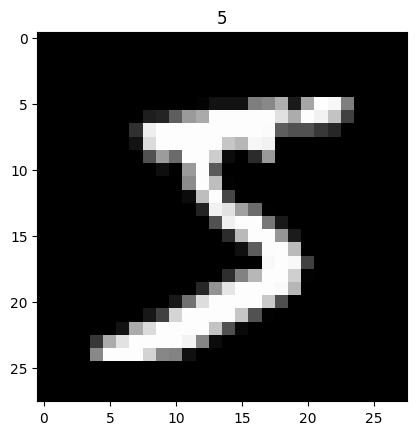

훈련용 데이터의 형태:  (60000, 784) 테스트용 데이터의 형태 :  (10000, 784)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train,t_train),(x_test,t_test)=mnist.load_data()
#MNIST 읽어들이기
print(x_train.shape,x_test.shape)   #28X28의 손으로 쓴 문자

#각 픽셀의 값을 0-1 범위에 넣는다
x_train=x_train/255
x_test=x_test/255

#손으로 쓴 문자 이미지를 1개 표시
plt.imshow(x_train[0].reshape(28,28),cmap="gray")
plt.title(t_train[0])
plt.show()

#1차원으로 변환한다 
x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)
print("훈련용 데이터의 형태: ",x_train.shape,"테스트용 데이터의 형태 : ",x_test.shape)

In [9]:
epochs=20
batch_size=128
n_in_out=784  #입출력층의 뉴런 수
n_z=2 #잠재 변수의 수(차원 수)
n_mid=256 #중간층의 뉴런 수

In [8]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics #평가함수
from tensorflow.python.keras.layers import Input,Dense,Lambda
from tensorflow.python.keras import backend as K  #난수의 발생에 사용

In [15]:
#잠재 변수를 샘플링하기 위한 함수
def z_sample(args):
  mu, log_var=args   #잠재 변수의 평균값과 분산의 대수
  epsilon=K.random_normal(shape=K.shape(log_var),mean=0,stddev=1)
  return mu+epsilon*K.exp(log_var/2)  #Reparametrization Trick에 의해 잠재 변수를 구한다

In [16]:
#Encoder
x=Input(shape=(n_in_out,))
h_encoder=Dense(n_mid,activation="relu")(x)
mu=Dense(n_z)(h_encoder)
log_var=Dense(n_z)(h_encoder)
z = Lambda(z_sample,output_shape=(n_z,))([mu,log_var])

In [17]:
#Deocoder
mid_decoder=Dense(n_mid,activation="relu")  #뒤에서 사용
h_decoder=mid_decoder(z)
out_decoder=Dense(n_in_out,activation="sigmoid")  #뒤에서 사용
y=out_decoder(h_decoder)

In [23]:
#VAE의 모델을 생성
model_vae=Model(x,y)

#손실 함수
eps=1e-7  #log안이 0이 되는 것을 막는다
rec_loss=K.sum(-x*K.log(y+eps)-(1-x)*K.log(1-y+eps))/batch_size #재구성 오차


In [25]:
reg_loss=-0.5*K.sum(1+log_var-K.square(mu)-K.exp(log_var))/batch_size #정칙화 항
vae_loss=rec_loss+reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            514         dense_6[0][0]                    
____________________________________________________________________________________________

In [27]:
model_vae.fit(x_train,x_train,shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test,None))

Epoch 1/20
469/469 [==============================] - 5s 3ms/step - loss: 204.1400 - val_loss: 175.2866
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 173.3914 - val_loss: 168.1910
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 169.0622 - val_loss: 165.6711
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 166.7932 - val_loss: 163.8753
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 164.9823 - val_loss: 161.9205
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 163.2929 - val_loss: 160.4069
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 161.7976 - val_loss: 159.1784
Epoch 8/20
469/469 [==============================] - 1s 3ms/step - loss: 160.5601 - val_loss: 158.1519
Epoch 9/20
469/469 [==============================] - 1s 3ms/step - loss: 159.5417 - val_loss: 157.4892
Epoch 10/20
469/469 [==============================] - 1s 3ms/st

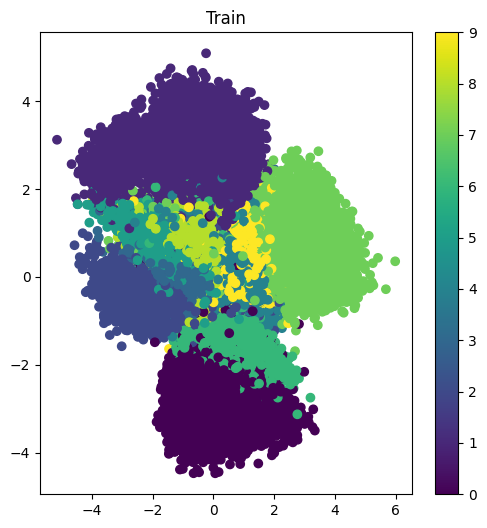

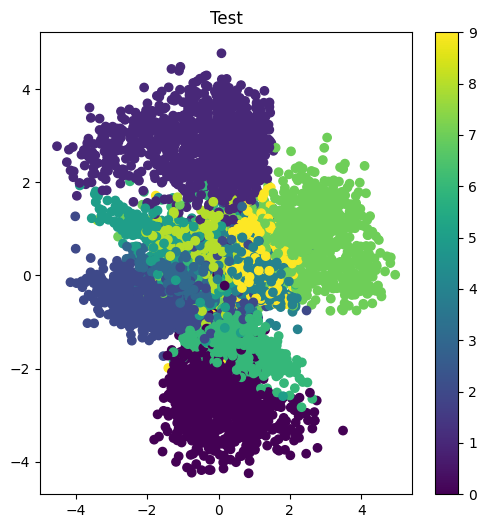

In [30]:
#잠재 변수를 얻기 위한 모델
encoder=Model(x,z)

#훈련 데이터로부터 만든 잠재 변수를 2차원 플롯
z_train=encoder.predict(x_train,batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_train[:,0],z_train[:,1],c=t_train) #라벨을 색으로 나타낸다
plt.title("Train")
plt.colorbar()
plt.show()

#테스트 데이터를 입력해서 잠재 공간에 2차원 플롯한다 정답 라벨을 색으로 표시
z_test=encoder.predict(x_test,batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_test[:,0],z_test[:,1],c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

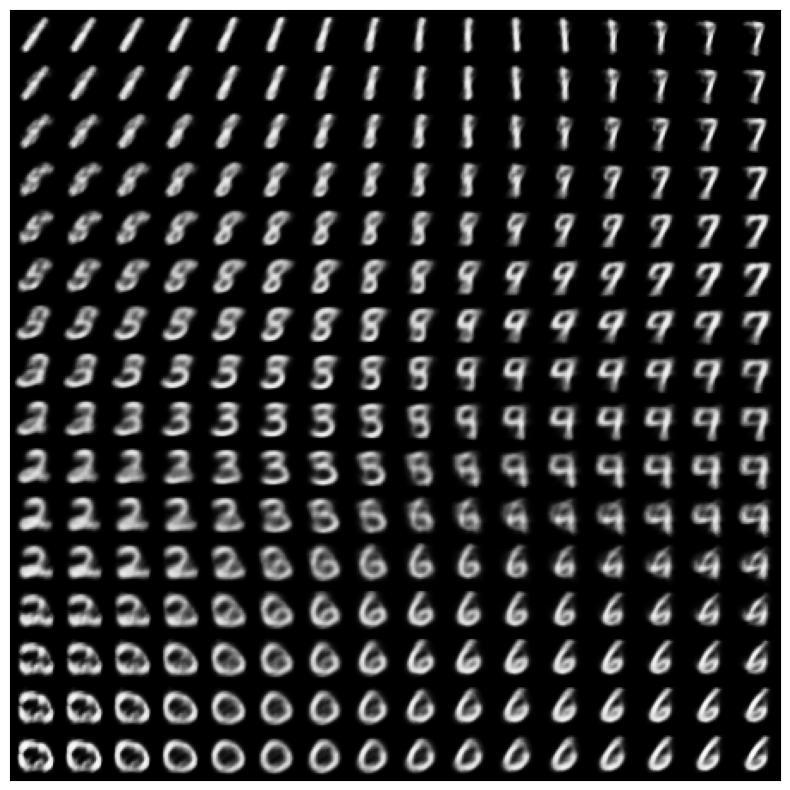

In [42]:
#이미지 생성식
input_decoder=Input(shape=(n_z,))
h_decoder=mid_decoder(input_decoder)
y=out_decoder(h_decoder)
generator=Model(input_decoder,y)

#이미지를 나열하는 설정
n=16  #손으로 쓴 문자 임지를 16x16 나열한다
image_size=28
matrix_image=np.zeros((image_size*n,image_size*n))  #전체 이미지

#잠재 변수
z_1=np.linspace(2,-2,n)   #각 행
z_2=np.linspace(-2,2,n)   #각 열

#잠재 변수를 변화시켜서 이미지를 생성
for i,z1 in enumerate(z_1):
  for j,z2 in enumerate(z_2):
    decoded=generator.predict(np.array([[z2,z1]])) #x축,y축의 순서로 넣는다
    image=decoded[0].reshape(image_size,image_size)
    matrix_image[i*image_size : (i+1)*image_size,
                 j*image_size: (j+1)*image_size] = image

plt.figure(figsize=(10,10))
plt.imshow(matrix_image,cmap="Greys_r")
plt.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)  #축 눈금의 라벨과 선을 지운다
plt.show()
